# Import libraries

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import regex as re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Connect Drive
from google.colab import drive
drive.mount('/content/drive')

# Import data
train = pd.read_csv("/content/drive/My Drive/train.csv")
test = pd.read_csv("/content/drive/My Drive/test.csv")
print('Dataset Loaded Successfully')

# Load glove dataset
gl_ds = open("/content/drive/My Drive/glove.6B.100d.txt")
#Global Variables
ip_addresses_count = 0

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Loaded Successfully


[link text](https://)#  [Extracting Labels and Data]



In [ ]:
# Extract data
X_train = train["comment_text"].fillna("__NaNNaNNaN__").values
X_test = test["comment_text"].fillna("__NaNNaNNaN__").values

# Extract labels
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_train = train[list_classes].values


# Exploratory Data Analysis

## Null Value Analysis

In [ ]:
def calculate_null_percentage(column):
    df_name = column.name
    nans = np.count_nonzero(column.isnull().values)
    total = column.size
    frac = nans / total
    perc = int(frac * 100)
    print('{}% or {} missing from {} column.'.format(perc, nans, df_name))

def check_null(df, columns):
    for col in columns:
        calculate_null_percentage(df[col])

check_null(train,train.columns)

0% or 0 missing from id column.
0% or 0 missing from comment_text column.
0% or 0 missing from toxic column.
0% or 0 missing from severe_toxic column.
0% or 0 missing from obscene column.
0% or 0 missing from threat column.
0% or 0 missing from insult column.
0% or 0 missing from identity_hate column.


## Labels and Records Analysis

In [ ]:
def analyse_labels_and_records(df):
  print('{} features and {} records.\n'.format(df.shape[1], df.shape[0]))
  targets = list(df.columns[2:])
  print('Target Labels: ' + ', '.join(targets))

analyse_labels_and_records(train)

8 features and 159571 records.

Target Labels: toxic, severe_toxic, obscene, threat, insult, identity_hate


## Head of train dataset

In [ ]:
for i in range(3):
    print('Comment #{}:  {}'.format(i + 1, X_train[i]))
    print('Label #{}:    {}'.format(i + 1, y_train[i]))
    print()

Comment #1:  Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Label #1:    [0 0 0 0 0 0]

Comment #2:  D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
Label #2:    [0 0 0 0 0 0]

Comment #3:  Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.
Label #3:    [0 0 0 0 0 0]



## Heatmap of the features

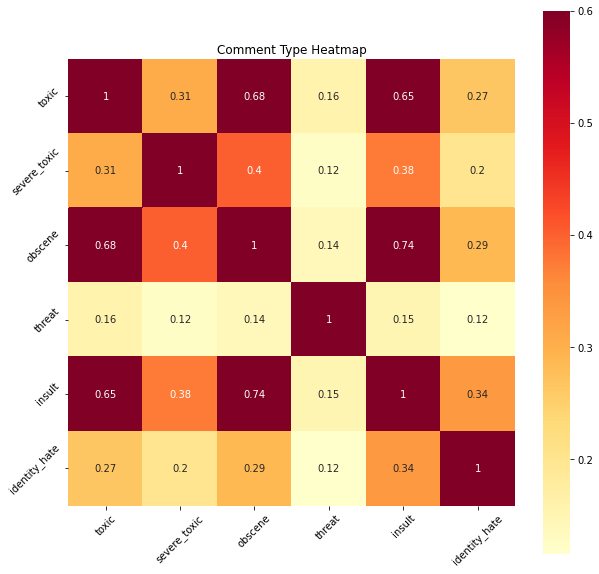

In [ ]:
def draw_heatmap(df, title):
    plt.figure('heatmap', figsize=[10,10])
    plt.title(title)
    df_corr = df.corr()
    sns.heatmap(df_corr, vmax=0.6, square=True, annot=True, cmap='YlOrRd')
    plt.yticks(rotation = 45)
    plt.xticks(rotation = 45)
    plt.show()

targets = list(train.columns[2:])
labels = train[targets].copy()
draw_heatmap(labels, 'Comment Type Heatmap')

## Class wise count of records

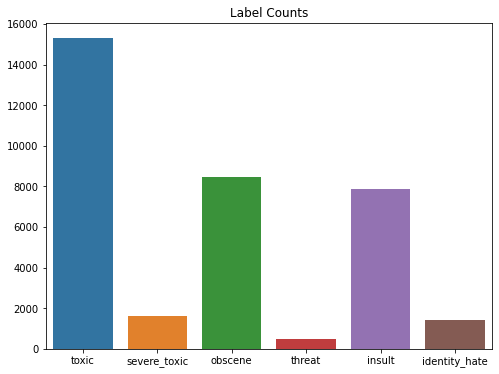

In [ ]:
def count_labels():
  count_track = {}
  for comment_type in targets:
      counts = list()
      others = list(labels)
      selection = labels[(labels[comment_type]==1)]
      others.remove(comment_type)
      counts.append(('total', len(selection)))
      for other in others:
          counts.append((other, selection[other].sum()))
      count_track[comment_type] = counts
  total_values = []
  for key, value in count_track.items():
    total_values.append(value[0][1])
  return count_track,total_values

labels_count,values = count_labels()
plt.figure('Label Counts', figsize=[8,6])
plt.title('Label Counts')
sns.barplot(x=list(labels_count.keys()), y=values)
plt.show()

## Vocabulary Exploration

In [ ]:
def explore_vocab():
  each_word_counter = collections.Counter([word for sentence in tqdm(X_train, total=len(X_train)) \
                                                              for word in sentence.split()])

  print('There are {} words.'.format(len([word for sentence in X_train for word in sentence.split()])))
  print('There are {} unique words'.format(len(each_word_counter)))
  print('Top 10 common words in the dataset are:')
  print('"' + '" "'.join(list(zip(*each_word_counter.most_common(10)))[0]) + '"')

explore_vocab()

100%|██████████| 159571/159571 [00:02<00:00, 57611.49it/s]


There are 10734904 words.
There are 532299 unique words
Top 10 common words in the dataset are:
"the" "to" "of" "and" "a" "I" "is" "you" "that" "in"


# Preprocessing Data

There are four important steps in pre-processing:


1.   Remove unwanted data such as special characters, ip-addresses.
2.   Make all words same case preferrably lower-case
3.   Tokenize the words so that Neural Network can understand what's happening with the input data
4.   Make all the sentences equal in length by padding zeros.



## Strip IP address

In [ ]:
def strip_ip(s, ip):
        try:
            found = ip.search(s)
            gr = found.group()
            global ip_addresses_count
            ip_addresses_count += 1
            return s.replace(gr, ' ')
        except:
            return s

# Ref: https://www.oreilly.com/library/view/regular-expressions-cookbook/9780596802837/ch07s16.html
ip = re.compile('(([2][5][0-5]\.)|([2][0-4][0-9]\.)|([0-1]?[0-9]?[0-9]\.)){3}'
                    +'(([2][5][0-5])|([2][0-4][0-9])|([0-1]?[0-9]?[0-9]))')

def print_info_message(label):
  global ip_addresses_count
  if ip_addresses_count == 0:
    print("No IP addresses found in {}!".format(label))
  else:
    print("{} IP addresses found in {} and replaced with \' \'".format(ip_addresses_count,label))
    
X_train = [strip_ip(comment,ip) for comment in X_train]
print_info_message('X_train')
X_test = [strip_ip(comment,ip) for comment in X_test]
print_info_message('X_test')


10081 IP addresses found in X_train and replaced with ' '
10833 IP addresses found in X_test and replaced with ' '


## Tokenize the dataset to remove special characters and convert all the characters to lower case

* Why this approach? Ref: https://developers.google.com/machine-learning/guides/text-classification/step-3#sequence_vectors_option_b

*   Find the maximum length of all the words by adding mean of the word length to the thrice of the standard deviation. 
*   Why should we multiply to the thrice of the standard deviation?
- Ref: McClelland, Robert. (2015). Re: Why should we multiply the standard deviation by 3 when we calculate the limit of detection?. Retrieved from: https://www.researchgate.net/post/Why_should_we_multiply_the_standard_deviation_by_3_when_we_calculate_the_limit_of_detection/56432e2b0f365f2ee78b4567/citation/download.



In [ ]:
tokenizer = Tokenizer(num_words=None,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', # filter the special characters
                      lower=True, # convert all characters to lower case
                      split=" ", # split the characters by space for tokenizing
                      char_level=False) # operate the tokenizer on word level not on character level since we are interested in the words that make the comment toxic and not the characters.

# Fit and run tokenizer to reduce the vocab size. We reduce the vocab size for making the vectorizer effecient.
tokenizer.fit_on_texts(list(X_train))
tokenized_train = tokenizer.texts_to_sequences(X_train)
tokenized_test = tokenizer.texts_to_sequences(X_test)
word_index = tokenizer.word_index

# Get the vocab size
vocab_size = len(word_index)

# find the longest word
longest = max(len(seq) for seq in tokenized_train)

# find the average word length
average = np.mean([len(seq) for seq in tokenized_train])

# find the standard deviation of the word length
standard_dev = np.std([len(seq) for seq in tokenized_train])

# Multiply standard_dev by 3 and add to the average to get the appropriate maximum length
max_len = int(average + standard_dev * 3)



## Pad the sentences with zeros if short in length

In [ ]:
# Pad the train data
processed_X_train = pad_sequences(tokenized_train, maxlen=max_len, padding='post', truncating='post')

# Pad the test data
processed_X_test = pad_sequences(tokenized_test, maxlen=max_len, padding='post', truncating='post')

# Comparing the vocab size

print("Before tokenizing the vocab size was: ",10734904)
print("After tokenizing the vocab size is: ",vocab_size)

Before tokenizing the vocab size was:  10734904
After tokenizing the vocab size is:  210065


## Embedding text

Now that we have tokenized each word, we will have to encode the text for feeding into the model. This can be done by using GloVe embedding

In [ ]:
embedding_idx = dict()
for every_line in gl_ds:
  values = every_line.split()
  word = values[0]
  coefs = np.asarray(values[1:],dtype='float32')
  embedding_idx[word] = coefs

gl_ds.close()

### Create Embedding matrix

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embedding_idx.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Modeling using GloVe embedded text

In [ ]:
import keras.backend
from keras.models import Sequential
from keras.layers import CuDNNGRU, Dense, Conv1D, MaxPooling1D
from keras.layers import Dropout, GlobalMaxPooling1D, BatchNormalization
from keras.layers import Bidirectional
from keras.layers.embeddings import Embedding
from tensorflow.keras.optimizers import Nadam

embedding_dim= 100
# Initate model
model = Sequential()


# Add Embedding layer
model.add(Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix],
                    input_length=max_len, trainable=True))

# Add Recurrent layers
model.add(Bidirectional(CuDNNGRU(300, return_sequences=True)))

# Add Convolutional layer
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(3))
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization())

# Add fully connected layers
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='sigmoid'))

# Summarize the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 370, 100)          21006600  
                                                                 
 bidirectional_1 (Bidirectio  (None, 370, 600)         723600    
 nal)                                                            
                                                                 
 conv1d_1 (Conv1D)           (None, 370, 128)          384128    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 123, 128)         0         
 1D)                                                             
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                      

### Compile the model

In [ ]:
import tensorflow as tf
def loss(y_true, y_pred):
     return keras.backend.binary_crossentropy(y_true, y_pred)

lr = .0001
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer=Nadam(lr=lr, clipnorm=1.0),
              metrics=['binary_accuracy'])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


### Metrics of the model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback

class RocAucEvaluation(Callback):
    def __init__(self, filepath, validation_data=(), interval=1, max_epoch = 100):
        super(Callback, self).__init__()
        # Initialize state variables
        self.interval = interval
        self.filepath = filepath
        self.stopped_epoch = max_epoch
        self.best = 0
        self.X_val, self.y_val = validation_data
        self.y_pred = np.zeros(self.y_val.shape)

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            current = roc_auc_score(self.y_val, y_pred)
            logs['roc_auc_val'] = current

            if current > self.best: #save model
                print("AUC improved from {:.5f} to {:.5f}".format(self.best, current))
                self.best = current
                self.y_pred = y_pred
                self.stopped_epoch = epoch+1
                self.model.save(self.filepath, overwrite=True)
            else:
                print("AUC did not improve")
            
[X, X_val, y, y_val] = train_test_split(processed_X_train, y_train, test_size=0.03, shuffle=False)
RocAuc = RocAucEvaluation(filepath='/content/drive/My Drive/saved_models/model.best.hdf5',validation_data=(X_val, y_val), interval=1)

### Training the model

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Set variables
batch_size = 64
epochs = 100

# Set early stopping
early_stop = EarlyStopping(monitor="roc_auc_val", mode="max", patience=2)
                                                    
# Train
X = X.astype(np.float32)
y = y.astype(np.float32)
graph = model.fit(X, y, batch_size=batch_size, epochs=epochs,
                  validation_data=(X_val, y_val), callbacks=[RocAuc, early_stop],
                  verbose=2, shuffle=False)

Epoch 1/100
 - AUC - improved from 0.00000 to 0.98013
2419/2419 - 225s - loss: 0.0477 - binary_accuracy: 0.9824 - val_loss: 0.0479 - val_binary_accuracy: 0.9833 - roc_auc_val: 0.9801 - 225s/epoch - 93ms/step
Epoch 2/100
 - AUC - improved from 0.98013 to 0.98384
2419/2419 - 228s - loss: 0.0441 - binary_accuracy: 0.9834 - val_loss: 0.0458 - val_binary_accuracy: 0.9834 - roc_auc_val: 0.9838 - 228s/epoch - 94ms/step
Epoch 3/100
 - AUC - did not improve
2419/2419 - 228s - loss: 0.0409 - binary_accuracy: 0.9844 - val_loss: 0.0468 - val_binary_accuracy: 0.9835 - roc_auc_val: 0.9835 - 228s/epoch - 94ms/step
Epoch 4/100
 - AUC - improved from 0.98384 to 0.98444
2419/2419 - 228s - loss: 0.0379 - binary_accuracy: 0.9853 - val_loss: 0.0492 - val_binary_accuracy: 0.9825 - roc_auc_val: 0.9844 - 228s/epoch - 94ms/step
Epoch 5/100
 - AUC - did not improve
2419/2419 - 228s - loss: 0.0354 - binary_accuracy: 0.9862 - val_loss: 0.0485 - val_binary_accuracy: 0.9816 - roc_auc_val: 0.9832 - 228s/epoch - 94ms

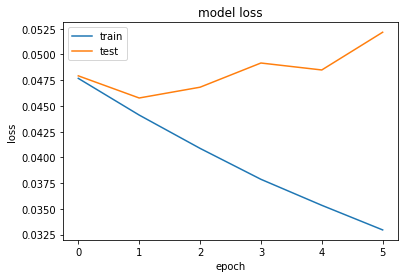

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Visualize history of loss
plt.plot(graph.history['loss'])
plt.plot(graph.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
def convert_text_to_token(text):
    token = [text]
    token = tokenizer.texts_to_sequences(token)
    token = pad_sequences(text, maxlen=max_len, padding='post', truncating='post')
    return token



### Convert the notebook to PDF

In [2]:
%%capture
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('toxic_comment_classification.ipynb')